# Imports

## Libraries

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# Standard Library Imports
import datetime
import io
import pickle
import re
import zipfile

# Third-Party Imports
from flaml import AutoML
import joblib
import matplotlib.pyplot as plt
import numpy as np
import optuna
from optuna_integration import OptunaSearchCV
import pandas as pd
import PyGRF
import requests
from scipy.stats import mode
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from skrub import DatetimeEncoder, TableVectorizer
import xgboost as xgb

# import tensorflow as tf
# from tensorflow.keras import Sequential, Input
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# from tensorflow.keras.layers import LSTM, Dense, Dropout
# from tensorflow.keras.optimizers import Adam

In [5]:
# # Set the number of threads for inter- and intra-op parallelism
# tf.config.threading.set_inter_op_parallelism_threads(12)
# tf.config.threading.set_intra_op_parallelism_threads(12)

## Data

### Provided data

In [6]:
# Import provided data
train = pd.read_parquet("/Users/pierrehaas/bike_counters/data/train.parquet")
test = pd.read_parquet("/Users/pierrehaas/bike_counters/data/final_test.parquet")

### External data

#### Weather data

In [7]:
# Import additionally sourced data

# https://meteo.data.gouv.fr/datasets/donnees-climatologiques-de-base-horaires/
weather = pd.read_csv(
    "/Users/pierrehaas/bike_counters/external_data/weather/H_75_previous-2020-2022.csv.gz",
    parse_dates=["AAAAMMJJHH"],
    date_format="%Y%m%d%H",
    compression="gzip",
    sep=";",
).rename(columns={"AAAAMMJJHH": "date"})

#### Public transport data

In [8]:
# https://data.iledefrance-mobilites.fr/explore/dataset/histo-validations-reseau-ferre/information/
# URLs of the zip files
urls = [
    "https://data.iledefrance-mobilites.fr/explore/dataset/histo-validations-reseau-ferre/files/e6bcf4c994951fc086e31db6819a3448/download/",
    "https://data.iledefrance-mobilites.fr/explore/dataset/histo-validations-reseau-ferre/files/e35b9ec0a183a8f2c7a8537dd43b124c/download/",
]

# Initialize an empty list to store DataFrames
dfs = []

# File matching pattern
pattern = r"data-rf-202\d/202\d_S\d+_NB_FER\.txt"

# Process each ZIP file
for url in urls:
    response = requests.get(url)
    if response.status_code == 200:
        with zipfile.ZipFile(io.BytesIO(response.content)) as z:
            # Get a list of all files in the archive and filter matching files
            matching_files = [f for f in z.namelist() if re.match(pattern, f)]

            # Read and concatenate the matching files
            for file in matching_files:
                with z.open(file) as f:
                    # Assuming the files are tab-separated and have a "JOUR" column
                    df = pd.read_csv(f, sep="\t", parse_dates=["JOUR"], dayfirst=True)
                    dfs.append(df)

# Combine all DataFrames
underground_transport = pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()


# # https://data.iledefrance-mobilites.fr/explore/dataset/histo-validations-reseau-surface/information/
# # URLs of the zip files
urls = [
    "https://data.iledefrance-mobilites.fr/explore/dataset/histo-validations-reseau-surface/files/41adcbd4216382c232ced4ccbf60187e/download/",
    "https://data.iledefrance-mobilites.fr/explore/dataset/histo-validations-reseau-surface/files/68cac32e8717f476905a60006a4dca26/download/",
]

# Initialize an empty list to store DataFrames
dfs = []

# File matching pattern
pattern = r"data-rs-202\d/202\d_T\d+_NB_SURFACE\.txt"

# Process each ZIP file
for url in urls:
    response = requests.get(url)
    if response.status_code == 200:
        with zipfile.ZipFile(io.BytesIO(response.content)) as z:
            # Get a list of all files in the archive and filter matching files
            matching_files = [f for f in z.namelist() if re.match(pattern, f)]

            # Read and concatenate the matching files
            for file in matching_files:
                with z.open(file) as f:
                    # Assuming the files are tab-separated and have a "JOUR" column
                    df = pd.read_csv(
                        f,
                        sep="\t",
                        parse_dates=["JOUR"],
                        dayfirst=True,
                        encoding="latin1",
                    )
                    dfs.append(df)

# Combine all DataFrames
overground_transport = pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()

#### Car traffic data

In [9]:
# URLs of the zip files
urls = [
    "https://parisdata.opendatasoft.com/api/datasets/1.0/comptages-routiers-permanents-historique/attachments/opendata_txt_2020_zip/",
    # "https://parisdata.opendatasoft.com/api/datasets/1.0/comptages-routiers-permanents-historique/attachments/opendata_txt_2021_zip/", # This file's compression format is broken, thus I provide a download link below
    "https://www.dropbox.com/scl/fi/sfqzlzpyxcf4yied3yucc/comptage-routier-2021.zip?rlkey=6k6hr3kywl8tvm4ax1qv2nv88&st=ktehiium&dl=1",
]

# Initialize an empty list to store DataFrames
dfs = []

# Process each ZIP file
for i, url in enumerate(urls):
    response = requests.get(url)
    if response.status_code == 200:
        with zipfile.ZipFile(io.BytesIO(response.content)) as z:
            # Process every file in the archive
            for file in z.namelist():
                # Skip directories and __MACOSX files
                if file.endswith("/") or "__MACOSX" in file:
                    continue
                # For the second URL, ensure files are within "comptage-routier-2021" directory
                if i == 1 and not file.startswith("comptage-routier-2021/"):
                    continue
                with z.open(file) as f:
                    # Assuming the files are semicolon-separated and have a "t_1h" column
                    df = pd.read_csv(f, sep=";", parse_dates=["t_1h"])
                    dfs.append(df)

# Combine all DataFrames
cars_count = pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()

#### Multimodal traffic data

In [10]:
multimodal_traffic = pd.read_parquet(
    "/Users/pierrehaas/Desktop/z_bin/data/comptage-multimodal-comptages.parquet"
)

In [11]:
# # URL of the Parquet file
# url = "https://parisdata.opendatasoft.com/api/explore/v2.1/catalog/datasets/comptage-multimodal-comptages/exports/parquet?lang=fr&timezone=Europe%2FParis"

# # Send a GET request to download the file
# response = requests.get(url)

# # Check if the request was successful
# if response.status_code == 200:
#     # Load the content into a Pandas DataFrame
#     parquet_file = io.BytesIO(response.content)
#     multimodal_traffic = pd.read_parquet(parquet_file)

# Data preparation | Feature engineering

## Date encoding

In [12]:
def date_encoder(X, col="date"):
    """
    Preprocesses a DataFrame by extracting and encoding various date-related features from a specified date column.

    Parameters:
    X (pd.DataFrame): The input DataFrame containing the date column.
    col (str): The name of the date column to be processed. Default is "date".

    Returns:
    pd.DataFrame: The updated DataFrame with new date-related features.
    """

    X = X.copy()  # modify a copy of X

    # Encode the date information from the DateOfDeparture columns
    X["year"] = X[col].dt.year
    X["quarter"] = X[col].dt.quarter
    X["month"] = X[col].dt.month
    X["month_scaled"] = np.cos(2 * np.pi * X["month"] / 12)
    X["weekofyear"] = X[col].dt.isocalendar().week
    X["day"] = X[col].dt.day
    X["weekday"] = X[col].dt.weekday + 1
    X["hour"] = X[col].dt.hour
    X["hour_scaled"] = np.cos(2 * np.pi * X["hour"] / 24)

    # Binary variable indicating weekend or not (1=weekend, 0=weekday)
    X["is_weekend"] = (X["weekday"] > 5).astype(int)

    # Binary variable indicating bank holiday or not (1=holiday, 0=not holiday)
    import holidays

    fr_bank_holidays = holidays.FR()  # Get list of FR holidays
    X["is_bank_holiday"] = X[col].apply(lambda x: 1 if x in fr_bank_holidays else 0)

    X = X.copy()  # modify a copy of X

    # Binary variable indicating school holiday or not (1=holiday, 0=not holiday)
    # https://www.data.gouv.fr/fr/datasets/vacances-scolaires-par-zones/
    fr_school_holidays = pd.read_csv(
        "/Users/pierrehaas/bike_counters/external_data/vacances_scolaires_france.csv"
    )[["date", "vacances_zone_c"]]

    # Ensure both DataFrames have a consistent datetime format
    X["date_normalized"] = pd.to_datetime(X[col]).dt.normalize()
    fr_school_holidays["date"] = pd.to_datetime(
        fr_school_holidays["date"]
    ).dt.normalize()

    # Create a dictionary from the holidays dataset for faster lookup
    holiday_mapping = dict(
        zip(fr_school_holidays["date"], fr_school_holidays["vacances_zone_c"])
    )

    # Map the normalized date to the holiday column
    X["is_school_holiday"] = (
        X["date_normalized"].map(holiday_mapping).fillna(0).astype(int)
    )

    # Drop the normalized date column if not needed
    X.drop(columns=["date_normalized"], inplace=True)

    # Finally, return the updated DataFrame
    return X

## Feature engineering on train and test data

In [13]:
def train_test_processing(X_train, X_test):
    """
    Preprocesses the training and testing datasets by adding various features.

    This function includes two main preprocessing steps:
    1. Calculating the distance of each station from a reference station.
    2. Adding COVID-19 related features such as lockdown and curfew indicators.
    3. Clustering the stations based on the mean log_bike_count.

    Parameters:
    X_train (pd.DataFrame): The training dataset containing features including 'latitude', 'longitude', 'site_name', and 'date'.
    X_test (pd.DataFrame): The testing dataset containing features including 'latitude', 'longitude', 'site_name', and 'date'.

    Returns:
    tuple: A tuple containing the processed training and testing datasets (X_train, X_test) with additional features.
    """

    def dist_station(X):
        """
        Calculate the distance from a specific station to all other stations.

        This function computes the Euclidean distance between the coordinates of a specific station
        ("Totem 73 boulevard de Sébastopol") and all other stations in the dataset.

        Parameters:
        X (pd.DataFrame): A DataFrame containing the columns 'latitude', 'longitude', and 'site_name'.

        Returns:
        np.ndarray: An array of distances from the specified station to all other stations.
        """

        lat_long_station = (
            X[["latitude", "longitude"]]
            - mode(
                X[X["site_name"] == "Totem 73 boulevard de Sébastopol"][
                    ["latitude", "longitude"]
                ]
            )[0]
        )

        # We calculate the distance the previously identified site to all others
        # We call the result the distance to the center since the station is close to the center of Paris
        dist_station = np.linalg.norm(
            lat_long_station,
            axis=1,
        )

        return dist_station

    def covid_features(X):
        """
        Adds COVID-19 related features to the dataset.

        This includes a binary variable indicating the presence of a lockdown and curfew periods.
        Lockdown and curfew dates are based on historical data from France.

        Parameters:
        X (pd.DataFrame): The dataset containing a 'date' column.

        Returns:
        pd.DataFrame: The dataset with additional COVID-19 related features.
        """

        # Create a binary variable indicating the presence of a lockdown
        # https://fr.wikipedia.org/wiki/Chronologie_de_la_pand%C3%A9mie_de_Covid-19_en_France
        lockdown_dates = [
            ("2020-10-30", "2020-12-15"),
            ("2021-04-03", "2021-05-03"),
        ]

        X["covid_lockdown"] = 0

        for start, end in lockdown_dates:
            X.loc[(X["date"] >= start) & (X["date"] < end), "covid_lockdown"] = 1

        curfew_dates = [
            ("2020-10-17", "2020-10-30", 21, 6),  # 21h-6h
            ("2020-12-16", "2021-01-15", 20, 6),  # 20h-6h
            ("2021-01-15", "2021-03-19", 19, 6),  # 19h-6h
            ("2021-03-20", "2021-04-03", 18, 6),  # 18h-6h
            ("2021-05-03", "2021-06-09", 19, 6),  # 19h-6h
            ("2021-06-09", "2021-06-20", 23, 6),  # 23h-6h
        ]

        X["covid_curfew"] = 0

        for start_date, end_date, start_hour, end_hour in curfew_dates:
            X.loc[
                (X["date"] >= start_date)
                & (X["date"] < end_date)
                & (X["hour"] >= start_hour)
                & (X["hour"] <= end_hour),
                "covid_curfew",
            ] = 1

        return X

    X_train, X_test = covid_features(X_train), covid_features(X_test)

    X_train["dist_to_station"] = dist_station(X_train)
    X_test["dist_to_station"] = dist_station(X_test)

    # Group by counter_name and calculate the mean log_bike_count
    grouped_train = (
        X_train.groupby("counter_name", observed=True)["log_bike_count"]
        .mean()
        .reset_index()
    )

    # Reshape the data for clustering
    Y = grouped_train[["log_bike_count"]]

    # Apply K-Means clustering
    kmeans = KMeans(n_clusters=5)
    grouped_train["cluster"] = kmeans.fit_predict(Y)

    # Sort clusters by mean log_bike_count and reassign cluster labels
    sorted_clusters = (
        grouped_train.groupby("cluster")["log_bike_count"].mean().sort_values().index
    )
    cluster_mapping = {
        old_label: new_label for new_label, old_label in enumerate(sorted_clusters)
    }
    grouped_train["cluster"] = grouped_train["cluster"].map(cluster_mapping)

    # Merge the cluster labels back to the original DataFrame
    X_train = X_train.merge(
        grouped_train[["counter_name", "cluster"]], on="counter_name", how="left"
    )
    X_test = X_test.merge(
        grouped_train[["counter_name", "cluster"]], on="counter_name", how="left"
    )

    return X_train, X_test

## Feature engineering on weather data

In [14]:
def weather_processing(X, train_min, train_max, test_min, test_max):
    """
    Preprocesses weather data and applies PCA to extract principal components.

    This function performs the following steps:
    1. Drops unnecessary columns and groups the data by date.
    2. Calculates various weather-related features, including lagged and future values.
    3. Adds binary indicators for rain and maximum temperature for each day.
    4. Splits the data into training and testing sets based on provided date ranges.
    5. Applies PCA to reduce the dimensionality of the weather features.
    6. Merges the PCA components with additional weather-related features.

    Parameters:
    X (pd.DataFrame): The input weather dataset containing various weather-related columns.
    train_min (str): The start date for the training set (inclusive).
    train_max (str): The end date for the training set (inclusive).
    test_min (str): The start date for the testing set (inclusive).
    test_max (str): The end date for the testing set (inclusive).

    Returns:
    pd.DataFrame: A DataFrame containing the PCA components and additional weather-related features.
    """

    X_reduced = (
        X.drop(columns=["NUM_POSTE", "NOM_USUEL", "LAT", "LON", "QDXI3S"])
        .groupby("date")
        .mean()
        .dropna(axis=1, how="all")
        .interpolate(method="linear")
    )

    X_reduced["is_rain"] = (X_reduced["RR1"] > 0).astype(int)

    X_reduced["q_rain_lag_1h"] = X_reduced["RR1"].shift(1)
    X_reduced["t_rain_lag_1h"] = X_reduced["DRR1"].shift(1)
    X_reduced["is_rain_lag_1h"] = X_reduced["is_rain"].shift(1)

    X_reduced["q_rain_next_1h"] = X_reduced["RR1"].shift(-1)
    X_reduced["t_rain_next_1h"] = X_reduced["DRR1"].shift(-1)
    X_reduced["is_rain_next_1h"] = X_reduced["is_rain"].shift(-1)

    X_reduced["temp_lag_1h"] = X_reduced["T"].shift(1)
    X_reduced["temp_next_1h"] = X_reduced["T"].shift(-1)

    X_reduced["max_temp"] = X_reduced.groupby(X_reduced.index.date)["T"].transform(
        "max"
    )
    X_reduced["will_rain"] = (
        X_reduced.groupby(X_reduced.index.date)["RR1"]
        .transform(lambda x: (x > 0).any())
        .astype(int)
    )

    weather_features = [
        "RR1",
        "DRR1",
        "T",
        "TNSOL",
        "TCHAUSSEE",
        "U",
        "GLO",
        "q_rain_lag_1h",
        "t_rain_lag_1h",
        "q_rain_next_1h",
        "t_rain_next_1h",
        "temp_lag_1h",
        "temp_next_1h",
        "max_temp",
    ]

    X_reduced_train = X_reduced[
        (X_reduced.index >= train_min) & (X_reduced.index <= train_max)
    ]

    X_reduced_test = X_reduced[
        (X_reduced.index >= test_min) & (X_reduced.index <= test_max)
    ]

    n = 5
    pca = PCA(n_components=n)

    pca.fit(X_reduced_train[weather_features])

    X_pca_train = pca.transform(X_reduced_train[weather_features])
    X_pca_test = pca.transform(X_reduced_test[weather_features])

    X_pca_train = pd.DataFrame(
        X_pca_train,
        index=X_reduced_train[weather_features].index,
        columns=["weather_" + str(i) for i in range(1, n + 1)],
    ).reset_index()

    X_pca_test = pd.DataFrame(
        X_pca_test,
        index=X_reduced_test[weather_features].index,
        columns=["weather_" + str(i) for i in range(1, n + 1)],
    ).reset_index()

    X_pca = pd.concat([X_pca_train, X_pca_test], ignore_index=True)

    X_pca = X_pca.merge(
        X_reduced[(X_reduced.index >= train_min) & (X_reduced.index <= test_max)][
            ["is_rain", "is_rain_lag_1h", "is_rain_next_1h", "will_rain"]
        ],
        on="date",
    )

    return X_pca

## Processing of public transport data

In [15]:
def transport_processing(X1, X2, train_min="2020-09-01", test_max="2021-10-18"):
    """
    Preprocesses transport data by aggregating daily validations and encoding date-related features.

    This function performs the following steps:
    1. Aggregates daily validation counts from two datasets.
    2. Combines the aggregated counts from both datasets.
    3. Encodes various date-related features using the `date_encoder` function.
    4. Filters the data based on the specified date range.

    Parameters:
    X1 (pd.DataFrame): The first dataset containing transport data with columns 'JOUR' (date) and 'NB_VALD' (number of validations).
    X2 (pd.DataFrame): The second dataset containing transport data with columns 'JOUR' (date) and 'NB_VALD' (number of validations).
    train_min (str): The start date for the training set (inclusive). Default is "2020-09-01".
    test_max (str): The end date for the testing set (inclusive). Default is "2021-10-18".

    Returns:
    pd.DataFrame: A DataFrame containing the aggregated and encoded transport data within the specified date range.
    """

    daily_X1 = X1.groupby("JOUR")["NB_VALD"].sum()
    daily_X2 = X2.groupby("JOUR")["NB_VALD"].sum()

    X = (daily_X1 + daily_X2).reset_index()

    X_reduced = date_encoder(X, col="JOUR")[
        (X["JOUR"] >= train_min) & (X["JOUR"] <= test_max)
    ]

    return X_reduced

## Processing of car traffic data

In [16]:
def car_traffic_processing(X, train_min, test_max):
    """
    Preprocesses car traffic data by aggregating hourly traffic counts and calculating daily cumulative sums.

    This function performs the following steps:
    1. Aggregates hourly traffic counts.
    2. Calculates the cumulative sum of traffic counts for each day.
    3. Filters the data based on the specified date range.

    Parameters:
    X (pd.DataFrame): The input dataset containing car traffic data with columns 't_1h' (timestamp) and 'q' (traffic count).
    train_min (str): The start date for the training set (inclusive).
    test_max (str): The end date for the testing set (inclusive).

    Returns:
    pd.DataFrame: A DataFrame containing the aggregated and processed car traffic data within the specified date range.
    """
    X_hourly = X.groupby("t_1h")["q"].sum().reset_index()

    # Group by day and calculate the cumulative sum of 'q' for each day
    X_hourly["daily_cumsum"] = X_hourly.groupby(X_hourly["t_1h"].dt.to_period("d"))[
        "q"
    ].cumsum()

    return X_hourly[(X_hourly["t_1h"] >= train_min) & (X_hourly["t_1h"] <= test_max)]

## Processing of multimodal traffic data

In [17]:
def mm_traffic_processing(X, train_min, test_max):
    """
    Preprocesses multimodal traffic data by encoding dates, removing bike counts, and calculating cumulative sums.

    This function performs the following steps:
    1. Encodes dates appropriately by removing timezone information.
    2. Removes bike counts to avoid feeding the model with the target variable.
    3. Aggregates hourly traffic counts for each mode of transport.
    4. Calculates the cumulative sum of traffic counts for each vehicle type every day.
    5. Combines the original hourly counts with the cumulative sums.
    6. Filters the data based on the specified date range and fills missing values with zero.

    Parameters:
    X (pd.DataFrame): The input dataset containing traffic data with columns 't' (timestamp), 'mode' (mode of transport), and 'nb_usagers' (number of users).
    train_min (str): The start date for the training set (inclusive).
    test_max (str): The end date for the testing set (inclusive).

    Returns:
    pd.DataFrame: A DataFrame containing the processed traffic data within the specified date range, with additional features.
    """

    # Encode dates appropriately like train and test sets
    X["date"] = X["t"].dt.tz_localize(None)

    # Remove bike count to avoid feeding the model with the target variable
    mask = (X["mode"] == "Trottinettes + vélos") | (X["mode"] == "Vélos")
    hourly_vehicle_count = (
        X[~mask].groupby(["date", "mode"])["nb_usagers"].sum().unstack()
    )

    # Group by day and calculate the cumulative sum of 'nb_usagers' for each vehicle type every day
    daily_cumsum_vh_type = (
        hourly_vehicle_count.groupby(hourly_vehicle_count.index.date)
        .cumsum()
        .rename(columns=lambda x: x + "_cumsum")
    )

    mm_traffic_features = pd.concat(
        [
            hourly_vehicle_count,
            daily_cumsum_vh_type,
        ],
        axis=1,
    ).reset_index()

    return mm_traffic_features[
        (mm_traffic_features["date"] >= train_min)
        & (mm_traffic_features["date"] <= test_max)
    ].fillna(0)

## Merging datasets

In [18]:
def data_engineered(
    df_train,
    df_test,
    weather,
    underground_transport,
    overground_transport,
    cars_count,
    mm_traffic_count,
):
    """
    Preprocesses and merges various datasets to create engineered features for training and testing.

    This function performs the following steps:
    1. Encodes date-related features in the training and testing datasets.
    2. Merges weather data, public transport data, car traffic data, and multimodal traffic data with the training and testing datasets.

    Parameters:
    df_train (pd.DataFrame): The training dataset containing a 'date' column.
    df_test (pd.DataFrame): The testing dataset containing a 'date' column.
    weather (pd.DataFrame): The weather dataset containing weather-related features and a 'date' column.
    underground_transport (pd.DataFrame): The underground transport dataset containing transport data with columns 'year', 'month', 'day', and 'NB_VALD'.
    overground_transport (pd.DataFrame): The overground transport dataset containing transport data with columns 'year', 'month', 'day', and 'NB_VALD'.
    cars_count (pd.DataFrame): The car traffic dataset containing traffic data with columns 't_1h' (timestamp) and 'q' (traffic count).
    mm_traffic_count (pd.DataFrame): The multimodal traffic dataset containing traffic data with columns 'date', 'mode', and 'nb_usagers'.

    Returns:
    tuple: A tuple containing the processed training and testing datasets (df_train, df_test) with merged features.
    """

    def merging_data(data, weather, public_transport, car_traffic, mm_traffic):
        """
        Merges weather, public transport, car traffic, and multimodal traffic data with the main dataset.

        Parameters:
        data (pd.DataFrame): The main dataset to merge with other datasets.
        weather (pd.DataFrame): The weather dataset containing weather-related features and a 'date' column.
        public_transport (pd.DataFrame): The public transport dataset containing transport data with columns 'year', 'month', 'day', and 'NB_VALD'.
        car_traffic (pd.DataFrame): The car traffic dataset containing traffic data with columns 't_1h' (timestamp) and 'q' (traffic count).
        mm_traffic (pd.DataFrame): The multimodal traffic dataset containing traffic data with columns 'date', 'mode', and 'nb_usagers'.

        Returns:
        pd.DataFrame: The merged dataset with additional features.
        """

        # Merge weather data
        data = data.merge(weather, on="date", how="left")

        # Merge public transport data
        data = data.merge(
            public_transport[["year", "month", "day", "NB_VALD"]],
            on=["year", "month", "day"],
            how="left",
        )

        # Merge car traffic data
        data = (
            data.merge(car_traffic, left_on="date", right_on="t_1h", how="left")
            .drop(columns=["t_1h"])
            .dropna()
            .reset_index(drop=True)
        )

        data = data.merge(mm_traffic, on="date", how="left")

        return data

    train_min, train_max = df_train["date"].min(), df_train["date"].max()
    test_min, test_max = df_test["date"].min(), df_test["date"].max()

    # Encoding the date
    df_train, df_test = date_encoder(df_train), date_encoder(df_test)

    # Processing the data
    df_train, df_test = train_test_processing(df_train, df_test)

    # Processing weather data
    weather_processed = weather_processing(
        weather, train_min, train_max, test_min, test_max
    )

    # Processing transport data
    transport_processed = transport_processing(
        underground_transport, overground_transport
    )

    # Processing car traffic data
    new_index = df_train["date"].unique().tolist() + df_test["date"].unique().tolist()
    car_traffic_processed = (
        car_traffic_processing(cars_count, train_min, test_max)
        .set_index("t_1h")
        .reindex(new_index)
        .interpolate(method="linear")
        .reset_index()
    )

    # Processing multimodal traffic data
    mm_traffic_processed = mm_traffic_processing(mm_traffic_count, train_min, test_max)

    # Merging the data
    df_train = merging_data(
        df_train,
        weather_processed,
        transport_processed,
        car_traffic_processed,
        mm_traffic_processed,
    )

    df_test = merging_data(
        df_test,
        weather_processed,
        transport_processed,
        car_traffic_processed,
        mm_traffic_processed,
    )

    return df_train, df_test

# Data preparation | Data cleaning | Pipeline creation

## Preparing data

In [19]:
df_train, X_test = data_engineered(
    train,
    test,
    weather,
    underground_transport,
    overground_transport,
    cars_count,
    multimodal_traffic,
)

df_train["total_seconds"] = DatetimeEncoder().fit_transform(df_train["date"])[
    "date_total_seconds"
]
X_test["total_seconds"] = DatetimeEncoder().fit_transform(X_test["date"])[
    "date_total_seconds"
]

df_train.sort_values(["date", "counter_id"], inplace=True)

y_train = df_train["log_bike_count"]

X_train = df_train.drop(
    columns=[
        "date",
        "counter_name",
        "site_name",
        "counter_installation_date",
        "bike_count",
        "log_bike_count",
    ],
)

X_test = X_test.drop(
    columns=[
        "date",
        "counter_name",
        "site_name",
        "counter_installation_date",
    ],
)

In [20]:
cols = [
    "2 roues motorisées",
    "Autobus et autocars",
    "Trottinettes",
    "Véhicules lourds > 3,5t",
    "Véhicules légers < 3,5t",
    "2 roues motorisées_cumsum",
    "Autobus et autocars_cumsum",
    "Trottinettes_cumsum",
    "Véhicules lourds > 3,5t_cumsum",
    "Véhicules légers < 3,5t_cumsum",
]

X_train[cols] = X_train[cols].fillna(0)

## Removing specific observations

In [21]:
# mask = (
#     X_train.groupby("counter_id", observed=True)["bike_count"]
#     .rolling(window=24)
#     .mean()
#     .reset_index(level=0, drop=True)
#     != 0
# )

# X_train_1 = X_train[mask.sort_index()]
# y_train_1 = X_train_1["log_bike_count"]

Doesn't seem to be necessary.

## Encoder selection

In [22]:
cols_to_scale = [
    "total_seconds",
    "weather_1",
    "weather_2",
    "weather_3",
    "weather_4",
    "weather_5",
    "weather_6",
    "weather_7",
    "weather_8",
    "weather_9",
    "weather_10",
    "NB_VALD",
    "q",
    "daily_cumsum",
    "2 roues motorisées",
    "Autobus et autocars",
    "Trottinettes",
    "Véhicules lourds > 3,5t",
    "Véhicules légers < 3,5t",
    "2 roues motorisées_cumsum",
    "Autobus et autocars_cumsum",
    "Trottinettes_cumsum",
    "Véhicules lourds > 3,5t_cumsum",
    "Véhicules légers < 3,5t_cumsum",
]

cols_to_label_encode = [
    "counter_id",
    "site_id",
    "coordinates",
    "counter_technical_id",
]

In [23]:
X_train.dtypes

counter_id                        category
site_id                              int64
coordinates                       category
counter_technical_id              category
latitude                           float64
longitude                          float64
year                                 int32
quarter                              int32
month                                int32
month_scaled                       float64
weekofyear                          UInt32
day                                  int32
weekday                              int32
hour                                 int32
hour_scaled                        float64
is_weekend                           int64
is_bank_holiday                      int64
is_school_holiday                    int64
covid_lockdown                       int64
covid_curfew                         int64
dist_to_station                    float64
cluster                              int64
weather_1                          float64
weather_2  

In [24]:
# Define the preprocessor
preprocessor = ColumnTransformer(
    [
        # ("scaler", StandardScaler(), cols_to_scale), # Specific for LSTM
        ("label_encoder", OrdinalEncoder(), cols_to_label_encode),
    ],
    remainder="passthrough",
)

# Fit and transform the data
preprocessor.fit(X_train)
X_train_enc = preprocessor.transform(X_train)
X_test_enc = preprocessor.transform(X_test)

# Get feature names from the transformers
# scaler_feature_names = [f"{col}_scaled" for col in cols_to_scale]
label_encoder_feature_names = [f"{col}_encoded" for col in cols_to_label_encode]
passthrough_feature_names = [
    col for col in X_train.columns if col not in cols_to_label_encode
]

# Combine all feature names
all_feature_names = label_encoder_feature_names + passthrough_feature_names

# Convert the numpy ndarray to a pandas DataFrame
X_train_enc_df = pd.DataFrame(X_train_enc, columns=all_feature_names)
X_test_enc_df = pd.DataFrame(X_test_enc, columns=all_feature_names)

# Convert data types explicitly
X_train_enc_df = X_train_enc_df.apply(pd.to_numeric, errors="coerce")
X_test_enc_df = X_test_enc_df.apply(pd.to_numeric, errors="coerce")

# Model selection

In [44]:
# automl = AutoML()
# automl.fit(
#     X_train_enc,
#     y_train,
#     task="regression",
#     metric="rmse",
#     time_budget=-1,
#     eval_method="cv",
#     n_splits=3,
#     split_type=TimeSeriesSplit(),
#     estimator_list=[
#         "histgb",
#         "catboost",
#         "kneighbor",
#         "extra_tree",
#         "rf",
#         "xgboost",
#         "xgb_limitdepth",
#         "sgd",
#     ],
# )

# # Save the model
# with open("/Users/pierrehaas/Desktop/automl_all_reg_models.pkl", "wb") as f:
#     pickle.dump(automl, f, pickle.HIGHEST_PROTOCOL)

# At prediction time
with open("/Users/pierrehaas/Desktop/data/automl_all_reg_models.pkl", "rb") as f:
    automl = pickle.load(f)

In [45]:
print(automl.best_estimator)
print(automl.best_config)
print(automl.best_loss)

extra_tree
{'n_estimators': 100}
0.7197809329716831


In [50]:
automl.best_loss_per_estimator

{'extra_tree': 0.7197809329716831,
 'histgb': 1.3561069089047844,
 'catboost': 0.7760460719513915,
 'kneighbor': 1.0453027735736415,
 'rf': 0.7594719596964115,
 'xgboost': 0.7769815120008294,
 'xgb_limitdepth': 0.7906507019951377,
 'sgd': 1.702659380010724}

In [51]:
pd.DataFrame(list(automl.best_loss_per_estimator.items()), columns=["Model", "Value"])

,Model,Value
0,extra_tree,0.719781
1,histgb,1.356107
2,catboost,0.776046
3,kneighbor,1.045303
4,rf,0.759472
5,xgboost,0.776982
6,xgb_limitdepth,0.790651
7,sgd,1.702659


In [46]:
print(automl.best_loss_per_estimator)

{'extra_tree': 0.7197809329716831, 'histgb': 1.3561069089047844, 'catboost': 0.7760460719513915, 'kneighbor': 1.0453027735736415, 'rf': 0.7594719596964115, 'xgboost': 0.7769815120008294, 'xgb_limitdepth': 0.7906507019951377, 'sgd': 1.702659380010724}


In [47]:
print(automl.best_config_per_estimator)

{'extra_tree': {'n_estimators': 100}, 'histgb': {'n_estimators': 4, 'max_leaves': 4, 'min_samples_leaf': 20, 'learning_rate': 0.09999999999999995, 'log_max_bin': 8, 'l2_regularization': 1.0, 'max_iter': 4}, 'catboost': {'early_stopping_rounds': 10, 'learning_rate': 0.09999999999999996, 'n_estimators': 8192}, 'kneighbor': {'n_neighbors': 5}, 'rf': {'n_estimators': 960, 'max_features': 0.6946169328587748, 'max_leaves': 8937}, 'xgboost': {'n_estimators': 6357, 'max_leaves': 206, 'min_child_weight': 1.9495322566288034, 'learning_rate': 0.0068766724195393905, 'subsample': 0.9451618245005704, 'colsample_bylevel': 0.9030482524943064, 'colsample_bytree': 0.9278972006416252, 'reg_alpha': 0.01857648400903689, 'reg_lambda': 6.021166480604588}, 'xgb_limitdepth': {'n_estimators': 4923, 'max_depth': 12, 'min_child_weight': 0.7625732991776795, 'learning_rate': 0.009239549681857523, 'subsample': 0.8193164619615052, 'colsample_bylevel': 0.7785754297307862, 'colsample_bytree': 0.788491073979525, 'reg_al

# Model finetuning

In [31]:
# optuna_parameters = {
#     "n_estimators": optuna.distributions.IntDistribution(50, 500),
#     "max_depth": optuna.distributions.IntDistribution(5, 50),
#     "min_samples_split": optuna.distributions.IntDistribution(2, 50),
#     "min_samples_leaf": optuna.distributions.IntDistribution(1, 50),
#     "max_features": optuna.distributions.CategoricalDistribution(
#         ["sqrt", "log2", None]
#     ),
# }

# model = ExtraTreesRegressor()

# optimiziming_etr = OptunaSearchCV(
#     model,
#     optuna_parameters,
#     n_jobs=-1,
#     cv=TimeSeriesSplit(n_splits=2),
#     scoring="neg_root_mean_squared_error",
#     n_trials=150,
# )

# optimiziming_etr.fit(X_train_enc, y_train)

# y_hat = optimiziming_etr.predict(X_test_enc)

# print(optimiziming_etr.best_params_)

In [32]:
# # Save the full pipeline with the best parameters
# joblib.dump(optimiziming_etr.best_estimator_, "/Users/pierrehaas/bike_counters/WIP/best_etr.joblib")

In [33]:
# etr_optimized = joblib.load("/Users/pierrehaas/bike_counters/WIP/best_etr.joblib")

# Final model fitting

## LSTM

In [34]:
# import numpy as np
# import pandas as pd

# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# from tensorflow.keras import mixed_precision
# from tensorflow.keras.regularizers import l2
# from sklearn.model_selection import train_test_split

# # Enable mixed precision
# mixed_precision.set_global_policy("mixed_float16")

# # Verify that TensorFlow is using the GPU
# print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices("GPU")))

# X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
#     X_train_enc, y_train, test_size=0.1, shuffle=False
# )

# split_index = int(len(X_train_s) * 0.8)
# X_train_s, X_train_val = X_train_s[:split_index], X_train_s[split_index:]
# y_train_s, y_train_val = y_train_s[:split_index], y_train_s[split_index:]

# # Suppose each sample is already [T, F] after reshaping
# T = 10
# F = X_train_s.shape[1] // T
# X_train_s = X_train_s.reshape((X_train_s.shape[0], T, F))
# X_train_val = X_train_val.reshape((X_train_val.shape[0], T, F))
# X_test_s = X_test_s.reshape((X_test_s.shape[0], T, F))

# model = Sequential()
# model.add(Input(shape=(T, F)))  # Define the input shape here
# model.add(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001)))
# model.add(Dropout(0.3))
# model.add(LSTM(64))
# model.add(Dense(1, dtype="float32"))  # Ensure the output layer uses float32

# es = EarlyStopping(monitor="val_loss", patience=5)
# mc = ModelCheckpoint(
#     "/Users/pierrehaas/bike_counters/WIP/best_model.keras",
#     monitor="val_loss",
#     save_best_only=True,
# )

# model.compile(loss="mean_squared_error", optimizer=Adam(learning_rate=0.0005))
# model.fit(
#     X_train_s,
#     y_train_s,
#     epochs=50,
#     batch_size=32,
#     validation_data=(X_train_val, y_train_val),
#     callbacks=[es, mc],
#     verbose=1,
# )

# test_loss = model.evaluate(X_test_s, y_test_s, verbose=1)
# print("Test Loss:", test_loss)

In [35]:
# predictions = model.predict(X_test_enc.reshape((X_test_enc.shape[0], T, F)))

## ExtraTrees

In [36]:
model = ExtraTreesRegressor()

model.fit(
    X_train_enc_df,
    y_train,
)

y_pred = model.predict(X_test_enc_df)

In [37]:
# Get feature importances
importances = model.feature_importances_

# Display feature contributions
feature_importance_df = pd.DataFrame(
    {"Feature": X_train_enc_df.columns.values, "Importance": importances}
).sort_values(by="Importance", ascending=False)

In [38]:
feature_importance_df.head(10)

,Feature,Importance
14,hour_scaled,0.370264
21,cluster,0.163896
32,q,0.102895
13,hour,0.064381
22,weather_1,0.028950
0,counter_id_encoded,0.023511
33,daily_cumsum,0.022199
31,NB_VALD,0.015664
36,Trottinettes,0.013329
9,month_scaled,0.013212


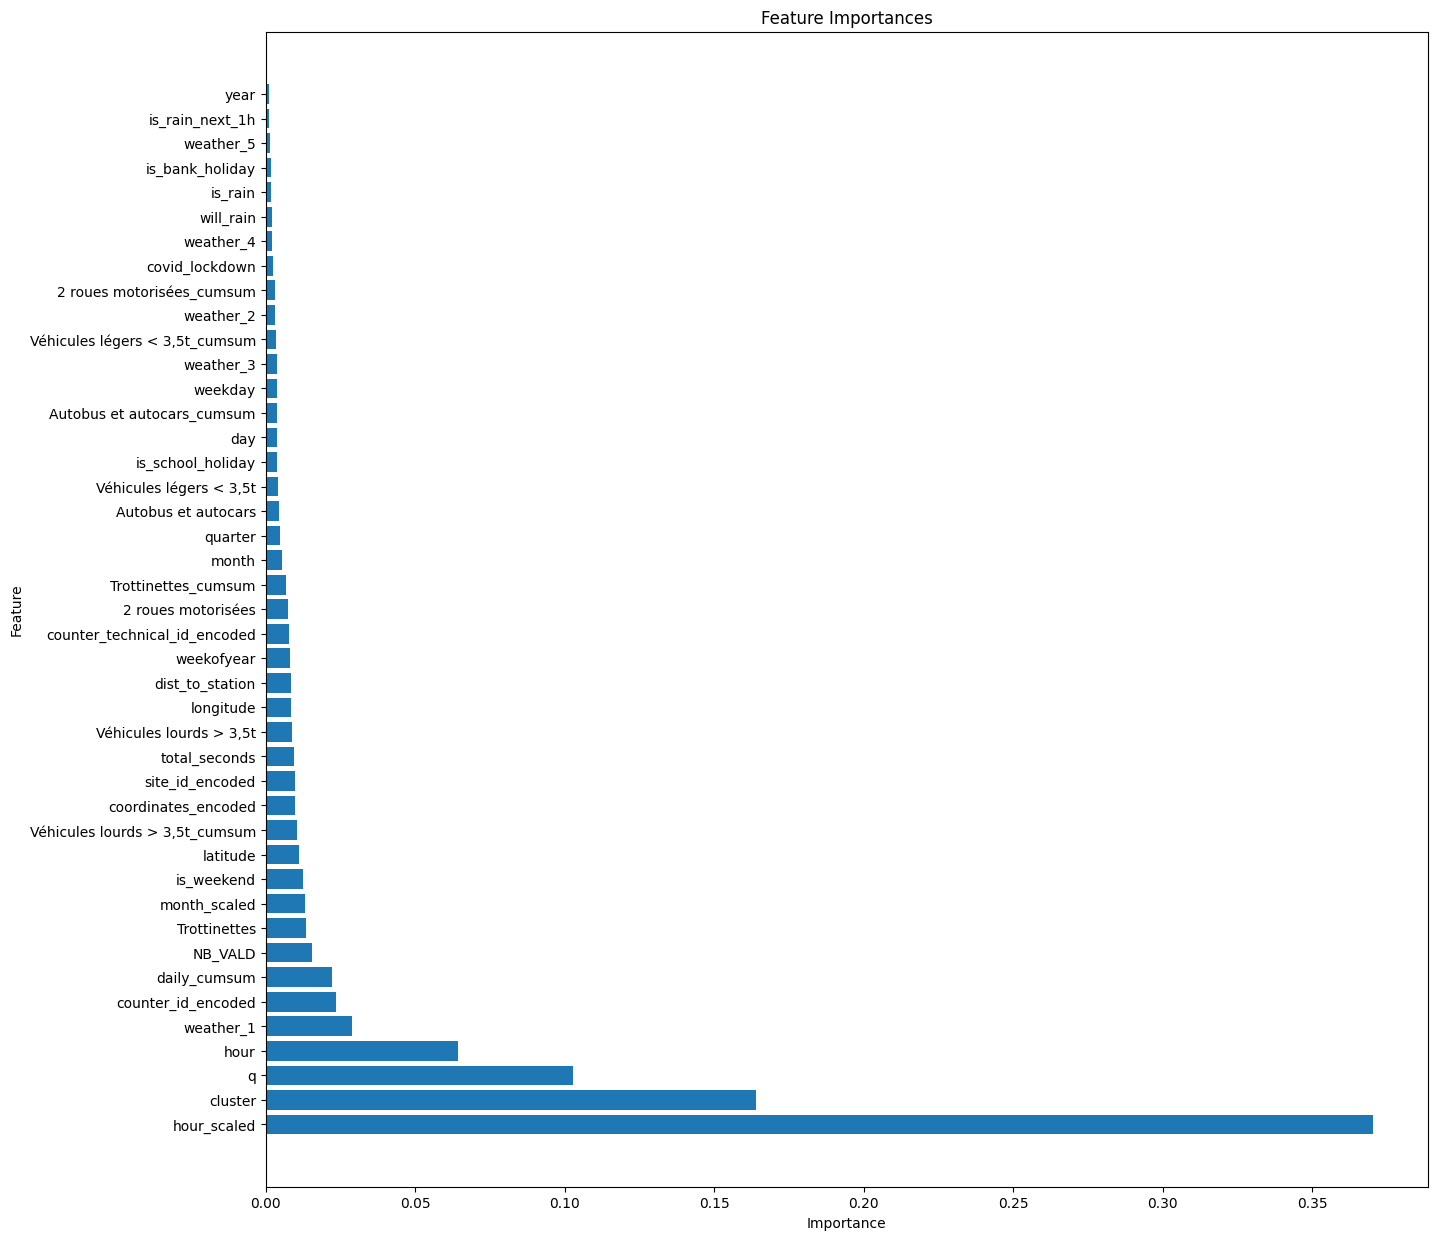

In [39]:
plt.figure(figsize=(15, 15))
plt.barh(
    feature_importance_df[feature_importance_df["Importance"] > 0.001]["Feature"],
    feature_importance_df[feature_importance_df["Importance"] > 0.001]["Importance"],
)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importances")
plt.show()

## Geographical RandomForest

In [40]:
# coords = ["latitude", "longitude"]

In [41]:
# for_bandwidth = X_train_enc_df.merge(y_train, left_index=True, right_index=True, how="left").groupby(["year", "month", "day"] + coords)["log_bike_count"].sum().reset_index()

In [42]:
# coords = ["latitude", "longitude"]
# bandwidth, local_weight, p_value = PyGRF.search_bw_lw_ISA(
#     for_bandwidth["log_bike_count"], for_bandwidth[coords]
# )

In [43]:
# pygrf = PyGRF.PyGRFBuilder(
#     band_width=bandwidth,
#     train_weighted=True,
#     predict_weighted=True,
#     bootstrap=False,
#     resampled=True,
#     random_state=42,
# )

# pygrf.fit(X_train_enc_df.drop(columns=coords), y_train, X_train_enc_df[coords])

# predict_combined, predict_global, predict_local = pygrf.predict(
#     X_test_enc_df.drop(columns=coords), X_test_enc_df[coords], local_weight=local_weight
# )

# Export

In [56]:
pd.DataFrame(y_pred, columns=["log_bike_count"]).reset_index().rename(
    columns={"index": "Id"}
).to_csv("/Users/pierrehaas/bike_counters/predictions.csv", index=False)